In [25]:
import findspark
findspark.init()

import pyspark
import random

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt

fileName = "/Users/lingzhuo/Desktop/256/Stock/IBMStockData.csv"

#initial a spark cluster
spark = pyspark.sql.SparkSession.builder.appName("StockPrice").config("spark.some.config.option", "some-value").getOrCreate()
#spark = pyspark.sql.SparkSession.builder.master("local").appName("StockMarket").config("spark.executor.memory", "6gb").getOrCreate()
#Use spark.read() to access this. Loads a CSV file and returns the result as a DataFrame.
df = spark.read.csv(fileName, header=True, inferSchema=True)

In [26]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
data = df.select('Open','High','Low','Volume','Polarity','Close').toPandas()
print(data)
data['Close'] = data['Close'].shift(-15,fill_value= 0)
data.drop(data.tail(15).index,inplace=True)
print(data)
dataset = data.to_numpy()

          Open    High     Low  Volume  Polarity   Close
0       112.28  112.28  112.28     120  0.000000  112.28
1       112.53  112.70  112.28  134096  0.103571  112.30
2       112.28  112.36  112.15   20521  0.103571  112.17
3       112.17  112.36  112.17   20044  0.103571  112.33
4       112.32  112.36  112.12   21591  0.103571  112.25
...        ...     ...     ...     ...       ...     ...
427619  125.92  126.26  125.91   48228  0.000000  126.22
427620  126.22  126.41  126.22   44881  0.000000  126.41
427621  126.42  126.50  126.35   44224  0.000000  126.48
427622  126.49  126.60  126.44   59030  0.000000  126.59
427623  126.59  126.59  126.25  148971  0.000000  126.25

[427624 rows x 6 columns]
            Open      High      Low  Volume  Polarity   Close
0       112.2800  112.2800  112.280     120  0.000000  112.29
1       112.5300  112.7000  112.280  134096  0.103571  112.24
2       112.2800  112.3600  112.150   20521  0.103571  112.31
3       112.1700  112.3600  112.170   200

In [27]:
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

#Create the scaled training data set and test data set
train_data = dataset[0:training_data_len]
test_data = dataset[training_data_len :]

print(train_data[0], len(train_data))
print('-------------')
print(test_data[0], len(test_data))


#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.fit_transform(test_data)

print(scaled_train_data[0])
print('-------------')
print(scaled_test_data[0])

[112.28 112.28 112.28 120.     0.   112.29] 342088
-------------
[1.31880000e+02 1.31880000e+02 1.31860000e+02 2.58500000e+03
 1.56850649e-01 1.31960000e+02] 85521
[2.29371079e-01 2.28814922e-01 2.30633237e-01 5.44928034e-06
 5.00000000e-01 2.29481815e-01]
-------------
[0.62020906 0.61720528 0.62689739 0.00102515 0.55032035 0.62140417]


In [28]:
xtrain = scaled_train_data[:, 0:-1]
ytrain = scaled_train_data[:, -1:]

xtest = scaled_test_data[:, 0:-1]
ytest = scaled_test_data[:, -1:]

print('xtrain shape = {}'.format(xtrain.shape))
print('xtest shape = {}'.format(xtest.shape))
print('ytrain shape = {}'.format(ytrain.shape))
print('ytest shape = {}'.format(ytest.shape))

xtrain shape = (342088, 5)
xtest shape = (85521, 5)
ytrain shape = (342088, 1)
ytest shape = (85521, 1)


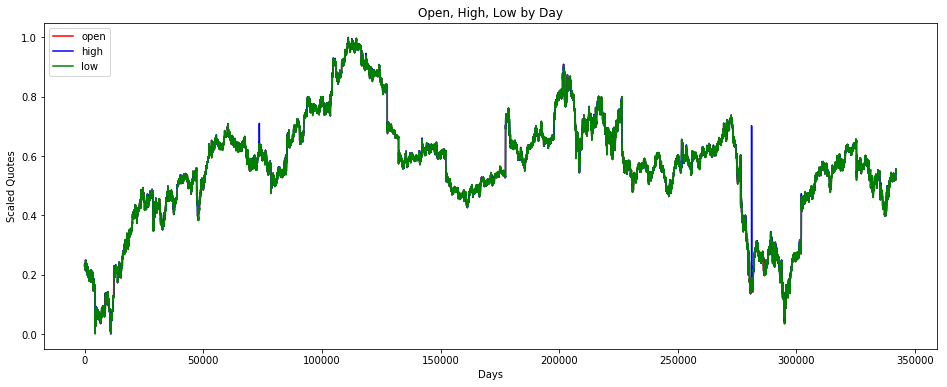

In [29]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.legend(loc = 'upper left')
plt.title('Open, High, Low by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

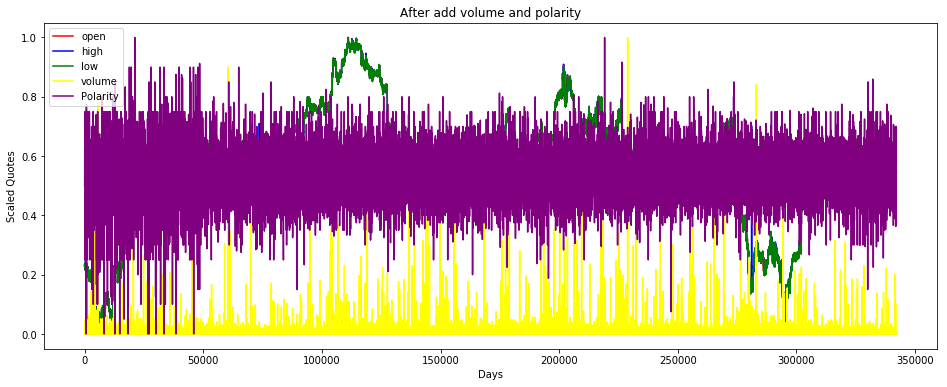

In [30]:
#volume and Polarity are very noisy
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.plot(xtrain[:,3],color='yellow', label='volume')
plt.plot(xtrain[:,4],color='purple', label='Polarity')
plt.legend(loc = 'upper left')
plt.title('After add volume and polarity')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [31]:
from keras import models, layers
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,5)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(xtrain.shape)
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest  = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))
print('The shape of xtrain is {}: '.format(xtrain.shape))
print('The shape of xtest is {}: '.format(xtest.shape))

loss = model.fit(xtrain, ytrain, batch_size=128, epochs=100)

(342088, 5)
The shape of xtrain is (342088, 1, 5): 
The shape of xtest is (85521, 1, 5): 
Epoch 1/100
342088/342088 [==============================] - 15s 42us/step - loss: 0.0234 0s -
Epoch 2/100
342088/342088 [==============================] - 13s 38us/step - loss: 2.8091e-04
Epoch 3/100
342088/342088 [==============================] - 11s 32us/step - loss: 1.5799e-04
Epoch 4/100
342088/342088 [==============================] - 16s 47us/step - loss: 8.6663e-05
Epoch 5/100
342088/342088 [==============================] - 13s 37us/step - loss: 5.4780e-05
Epoch 6/100
342088/342088 [==============================] - 13s 37us/step - loss: 4.2778e-05
Epoch 7/100
342088/342088 [==============================] - 13s 38us/step - loss: 3.7579e-05
Epoch 8/100
342088/342088 [==============================] - 12s 36us/step - loss: 3.5032e-05
Epoch 9/100
342088/342088 [==============================] - 12s 36us/step - loss: 3.3616e-05
Epoch 10/100
342088/342088 [==============================] - 1

342088/342088 [==============================] - 9s 27us/step - loss: 2.8067e-05
Epoch 87/100
342088/342088 [==============================] - 9s 26us/step - loss: 2.8068e-05
Epoch 88/100
342088/342088 [==============================] - 9s 26us/step - loss: 2.7970e-05
Epoch 89/100
342088/342088 [==============================] - 9s 25us/step - loss: 2.7919e-05
Epoch 90/100
342088/342088 [==============================] - 9s 27us/step - loss: 2.7928e-05
Epoch 91/100
342088/342088 [==============================] - 9s 26us/step - loss: 2.7848e-05
Epoch 92/100
342088/342088 [==============================] - 9s 28us/step - loss: 2.8027e-05
Epoch 93/100
342088/342088 [==============================] - 9s 27us/step - loss: 2.7825e-05
Epoch 94/100
342088/342088 [==============================] - 9s 27us/step - loss: 2.8029e-05
Epoch 95/100
342088/342088 [==============================] - 9s 27us/step - loss: 2.7907e-05: 0s
Epoch 96/100
342088/342088 [==============================] - 10s 28u

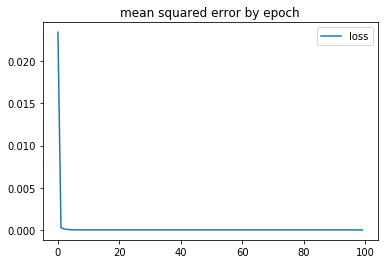

In [32]:
plt.plot(loss.history['loss'], label = 'loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show()

In [33]:
#Getting the models predicted price values
predictions = model.predict(xtest) 
print(predictions)

[[0.6228516 ]
 [0.6227401 ]
 [0.6227422 ]
 ...
 [0.54554594]
 [0.5448427 ]
 [0.54421943]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


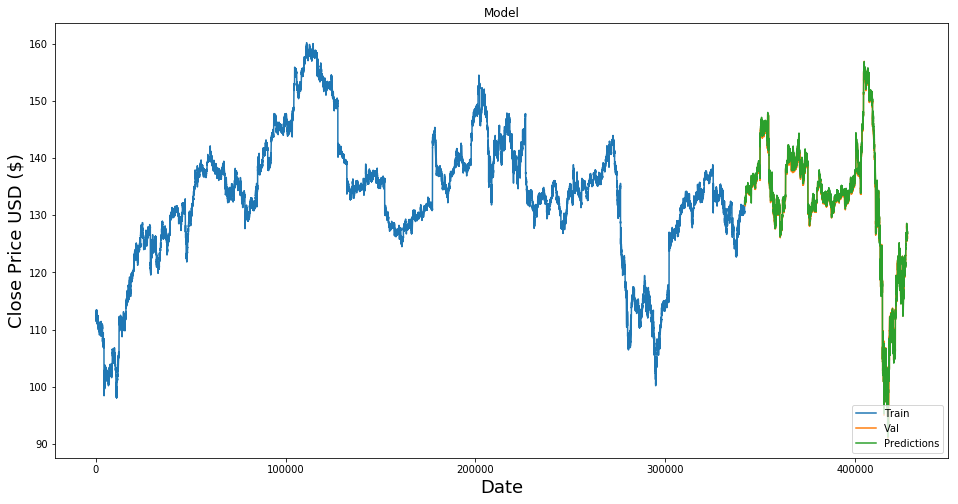

In [34]:
#Undo scaling, show real prediction
# create empty table with 2 fields
trainPredict_dataset_like = np.zeros(shape=(len(predictions), 6) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = predictions[:,0]
# inverse transform and then select the right field
predictions = scaler.inverse_transform(trainPredict_dataset_like)[:,0]


train = data.loc[:training_data_len]
valid = data.loc[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [35]:
#Show the valid and predicted prices
valid

,Open,High,Low,Volume,Polarity,Close,Predictions
342088,131.8800,131.8800,131.860,2585,0.156851,131.96,132.054435
342089,131.8800,131.8800,131.850,8248,0.156851,131.98,132.047073
342090,131.8500,131.8800,131.840,5726,0.156851,132.02,132.047211
342091,131.8500,131.8800,131.850,5811,0.156851,132.03,132.051382
342092,131.8700,131.8900,131.860,5559,0.267929,132.05,132.060765
...,...,...,...,...,...,...,...
427604,126.8700,126.8900,126.790,9952,0.000000,126.22,126.941655
427605,126.8300,126.9100,126.822,4521,0.000000,126.41,126.975527
427606,126.8928,126.8928,126.810,6319,0.000000,126.48,126.951487
427607,126.8800,126.8800,126.720,8027,0.000000,126.59,126.905068


In [36]:
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
from pyspark.ml.evaluation import RegressionEvaluator

df = valid[['Predictions', 'Close']]
print(df)
df_predictions = spark.createDataFrame(df)
rmse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="rmse")
rmse = rmse_evaluator.evaluate(df_predictions)

mse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="mse")
mse = mse_evaluator.evaluate(df_predictions)

mae_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="mae")
mae = mae_evaluator.evaluate(df_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Square Error (MSE) on test data = %g" % mse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

        Predictions   Close
342088   132.054435  131.96
342089   132.047073  131.98
342090   132.047211  132.02
342091   132.051382  132.03
342092   132.060765  132.05
...             ...     ...
427604   126.941655  126.22
427605   126.975527  126.41
427606   126.951487  126.48
427607   126.905068  126.59
427608   126.863925  126.25

[85521 rows x 2 columns]
Root Mean Squared Error (RMSE) on test data = 0.615475
Mean Square Error (MSE) on test data = 0.37881
Mean Absolute Error (MAE) on test data = 0.378514
